<a href="https://colab.research.google.com/github/rshlomi/SpykeTorch/blob/master/SNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spiking neural network, based on the paper:

> <cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning". arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>

as well as the accompanying [tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

In [1]:
!pip install snntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 2.4 MB/s 


In [2]:
# imports
import snntorch as snn # main snntorch package
from snntorch import spikeplot as splt # plotting utilities

import torch # PyTorch
import torch.nn as nn # for Linear and Loss
from torch.utils.data import DataLoader # for loading MNIST training and testing data
from torchvision import datasets, transforms
from  numpy import mean

device = torch.device("cpu") # hardware

In [3]:
# Network Architecture
side = 28
num_inputs = side * side
num_hidden = 1000 # neurons in hidden layer
num_outputs = 10 # one for each digit

# Temporal Dynamics
num_steps = 25
beta = 0.95 # decay coefficient (fraction of membrane potential to be carried over to next time step)

In [4]:
# Define a transform to be applied to MNIST dataset
transform = transforms.Compose([
            transforms.Resize((side, side)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Get the static MNIST dataset (handwritten digits), often used for benchmarking neural networks
batch_size = 128
mnist_train = datasets.MNIST('/data/mnist', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('/data/mnist', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/mnist/MNIST/raw



In [5]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden) # input layer
        self.lif1 = snn.Leaky(beta=beta) # leaky integrate-and-fire
        self.linear2 = nn.Linear(num_hidden, num_outputs) # apply a linear transformation
        self.lif2 = snn.Leaky(beta=beta) # output layer

    def forward(self, x):

        # Membrabe potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # output lists
        spk2_rec = []
        mem2_rec = []

        step = 0
        while step < num_steps:
            current = self.linear1(x)
            spk1, mem1 = self.lif1(current, mem1) # Use output from first layer as input to second layer
            current = self.linear2(spk1)
            spk2, mem2 = self.lif2(current, mem2) # Use output from third layer as input to fourth layer
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            step += 1

        # convert list of tensors to one tensor
        spikes = torch.stack(spk2_rec, dim=0)
        mem_potentials = torch.stack(mem2_rec, dim=0)
        return spikes, mem_potentials
        
# Load the network onto CPU
net = Net().to(device)

In [6]:
# pass data into the network, 
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1)) # resize data and pass into SNN
    s1 = output.sum(dim=0) # sum the spikes over time
    _, idx = s1.max(1) # don't need first argument (max value); second is the index of the max

    acc = mean((targets == idx).detach().cpu().numpy())

    tt = "Train" if train else "Test"
    print(f"{tt} set accuracy for a single minibatch: {acc*100:.2f}%")

def accuracy_loss_monitor():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

The practical effect of choosing a **cross-entropy** loss function is that the membrane potential of the correct ouput (class) is "encouraged" to increase, while all of the others are reduced.

In [7]:
loss = nn.CrossEntropyLoss()

# robust optimizer that performs well on recurrent networks
optimizer = torch.optim.Adam(net.parameters())

In [8]:
num_epochs = 1 # number of times to use ALL of the data
train_loss_hist = []
test_loss_hist = []
counter = 0
print_freq = 50 # how often to print results
torch_zero = torch.zeros((1), dtype=torch.float, device=device) # loss initialization

# Outer training loop, for going over all of the data
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        _, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets) # cross-entropy defined ↑

        # Gradient calculation + weight update
        optimizer.zero_grad() # clear any previously stored gradients
        loss_val.backward() # compute the gradient of the loss tensor
        optimizer.step()

        # Store loss history (for plotting)
        train_loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % print_freq == 0:
                accuracy_loss_monitor()
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 62.60
Test Set Loss: 50.32
Train set accuracy for a single minibatch: 48.44%
Test set accuracy for a single minibatch: 38.28%


Epoch 0, Iteration 50
Train Set Loss: 16.02
Test Set Loss: 12.29
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 88.28%


Epoch 0, Iteration 100
Train Set Loss: 12.15
Test Set Loss: 14.09
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 150
Train Set Loss: 10.53
Test Set Loss: 13.81
Train set accuracy for a single minibatch: 90.62%
Test set accuracy for a single minibatch: 92.97%


Epoch 0, Iteration 200
Train Set Loss: 8.76
Test Set Loss: 9.07
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 95.31%


Epoch 0, Iteration 250
Train Set Loss: 7.92
Test Set Loss: 4.28
Train set accuracy for a single minibatch: 95.31%
Test set accuracy for a single minibatch: 95.31%


Epoch

Training loss decreased from 62.60436248779297 to 8.95445728302002
and test loss decreased from 50.324798583984375 to 3.144619941711426
over the course of 468 iterations.


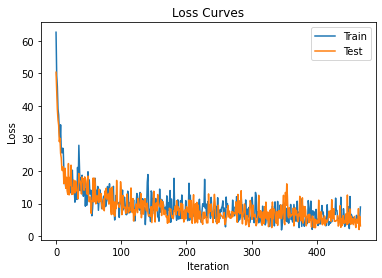

In [9]:
print(f"Training loss decreased from {train_loss_hist[0]} to {train_loss_hist[-1]}")
print(f"and test loss decreased from {test_loss_hist[0]} to {test_loss_hist[-1]}")
print(f"over the course of {len(train_loss_hist)} iterations.")

# Plot Loss evolution
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train", "Test"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [10]:
total = 0
corrects = 0

loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,
                         drop_last=False) # keep all samples

with torch.no_grad():
  net.eval()
  for data, targets in loader:
    data = data.to(device)
    targets = targets.to(device)
    
    # run the calibrated SNN (forward) to get output spike
    test_spk, _ = net(data.view(data.size(0), -1)) # only need spikes, not membrane potential

    # calculate total accuracy
    spike_sum = test_spk.sum(dim=0) # sum up spikes
    _, predicted = spike_sum.max(1) # get ouput index of max
    correct = (predicted == targets)
    correct = correct.sum()
    corrects += correct.item() # convert to scalar and add to tally
    total += targets.size(0)

print(f"Total correctly classified test set images: {corrects}/{total}")
print(f"Test Set Accuracy: {100 * corrects / total:.2f}%")

Total correctly classified test set images: 9578/10000
Test Set Accuracy: 95.78%
